
# Customer Segmentation — Unsupervised Learning

**Objective:** Identify distinct customer segments based on behavioral and demographic data using unsupervised learning techniques.

**Dataset:** Contains customer-related attributes such as annual income, spending score, and age.

**Approach:**
- Exploratory Data Analysis (EDA)
- Standardization of numeric features
- Clustering using **K-Means**
- Dimensionality reduction for visualization (**PCA**)
- Cluster interpretation and business insights

---


# Customer Segmentation (Unsupervised Learning)

**Goal:** Segment mall customers into distinct groups using clustering (K-Means) and visualize results with PCA.

**What this notebook contains:**
- Data loading (with fallback instructions)
- EDA & preprocessing
- Scaling & feature selection
- K-Means clustering (Elbow & Silhouette)
- PCA for 2D visualization
- Cluster profiling and business insights

---


## 1. Setup & Imports

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import os
sns.set(style='whitegrid')

## 2. Load the dataset

In [20]:

data_path='../data/Mall_Customers.csv'
# Show head
df = pd.read_csv(data_path)
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [21]:
df.rename(columns={
    'Annual Income (k$)': 'Annual_income',
    'Spending Score (1-100)': 'Spending_score',
    'Genre': 'Gender'
}, inplace=True)

In [22]:
df.head()

,CustomerID,Gender,Age,Annual_income,Spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## 3. Quick EDA

In [23]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      200 non-null    int64 
 1   Gender          200 non-null    object
 2   Age             200 non-null    int64 
 3   Annual_income   200 non-null    int64 
 4   Spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [24]:
# Summary statistics
df.describe(include='all')

,CustomerID,Gender,Age,Annual_income,Spending_score
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


In [25]:
# Check missing values
df.isna().sum()

CustomerID        0
Gender            0
Age               0
Annual_income     0
Spending_score    0
dtype: int64

In [26]:
# Rename columns if necessary for consistency
df.columns = [c.strip().replace(' ', '_').replace('(', '').replace(')', '') for c in df.columns]
df.head()

,CustomerID,Gender,Age,Annual_income,Spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Visualizations

- Age distribution
- Annual Income distribution
- Spending Score distribution
- Gender counts

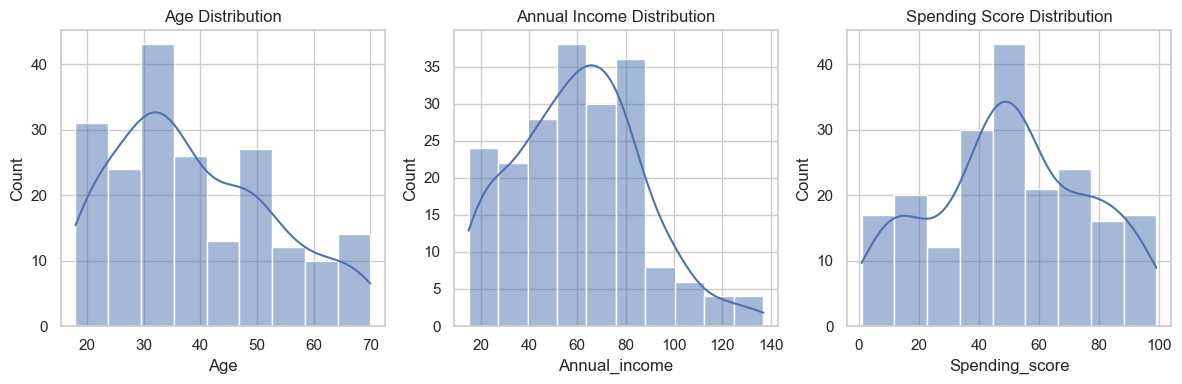

In [27]:
plt.figure(figsize=(12,4))

# Age Distribution
plt.subplot(1,3,1)
sns.histplot(df['Age'], kde=True)
plt.title('Age Distribution')

# Annual Income Distribution
plt.subplot(1,3,2)
sns.histplot(df['Annual_income'], kde=True)
plt.title('Annual Income Distribution')

# Spending Score Distribution
plt.subplot(1,3,3)
sns.histplot(df['Spending_score'], kde=True)
plt.title('Spending Score Distribution')

plt.tight_layout()
plt.show()


The age distribution shows most customers are between 25–40 years old, suggesting the mall attracts a relatively young audience.
Annual income has a near-uniform spread between 15k–140k, indicating a diverse customer base.
Spending score is fairly balanced, showing we have both high and low spenders, ideal for segmentation.

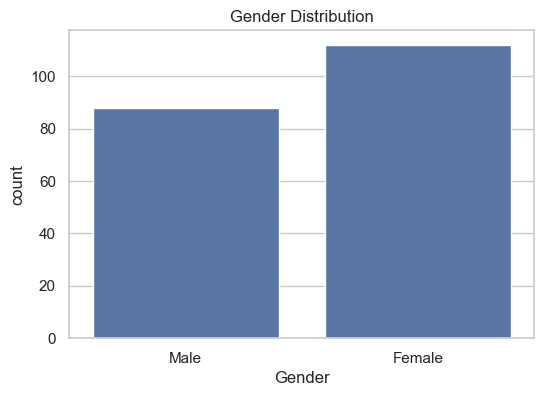

In [28]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['Gender'])
plt.title('Gender Distribution')
plt.show()

The gender distribution is slightly skewed toward females, but not drastically. This suggests both male and female customers are represented well in the dataset.

## 4. Preprocessing

In [29]:
from sklearn.preprocessing import StandardScaler

# Select features directly
features = df[['Age', 'Annual_income', 'Spending_score']].copy()

# Handle missing values
features = features.fillna(features.median())

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(features)

print('Selected features:', features.columns.tolist())
X[:5]


Selected features: ['Age', 'Annual_income', 'Spending_score']


array([[-1.42456879, -1.73899919, -0.43480148],
       [-1.28103541, -1.73899919,  1.19570407],
       [-1.3528021 , -1.70082976, -1.71591298],
       [-1.13750203, -1.70082976,  1.04041783],
       [-0.56336851, -1.66266033, -0.39597992]])

## 5. Finding the optimal number of clusters

C:\Users\benjo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benjo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benjo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\benjo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

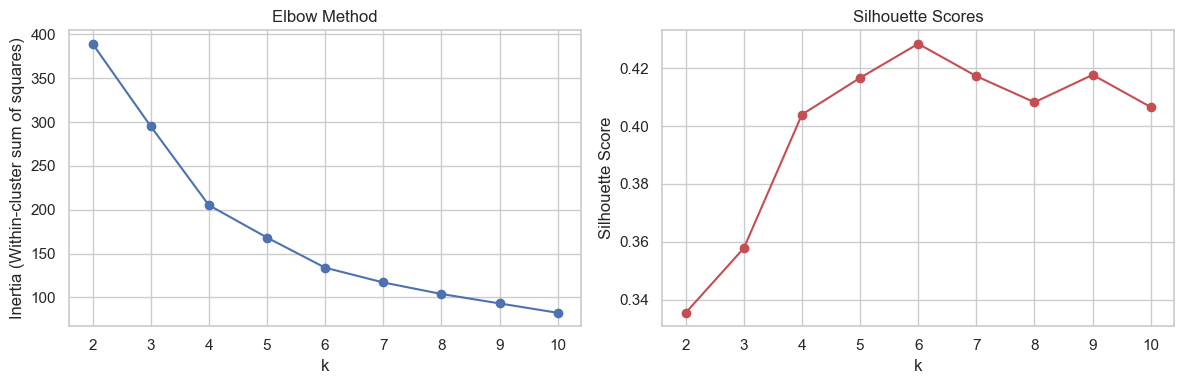

,k,inertia,silhouette
0,2,389.386189,0.335472
1,3,295.212246,0.357793
2,4,205.225147,0.403958
3,5,168.247580,0.416643
4,6,133.868421,0.428417
5,7,117.011555,0.417232
6,8,103.873292,0.408207
7,9,93.092891,0.417693
8,10,82.385154,0.406554


In [30]:
inertia = []
sil_scores = []
K = range(2,11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('k')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(K, sil_scores, 'ro-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.tight_layout()
plt.show()

pd.DataFrame({'k':list(K),'inertia':inertia,'silhouette':sil_scores})

The elbow plot flattens around k=5, meaning adding more clusters beyond 5 gives diminishing returns.
The silhouette score also peaks around k=5, confirming that 5 clusters provide the best balance between cohesion and separation.

## 6. Fit final K-Means

Choose k based on the plots above (commonly between 3 and 5 for this dataset). We'll use k=5 as a sensible default — change if your Elbow/Silhouette suggests another value.

In [31]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# Attach labels back to original df
df['Cluster'] = cluster_labels
df.head()

C:\Users\benjo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,CustomerID,Gender,Age,Annual_income,Spending_score,Cluster
0,1,Male,19,15,39,1
1,2,Male,21,15,81,1
2,3,Female,20,16,6,0
3,4,Female,23,16,77,1
4,5,Female,31,17,40,1


## 7. PCA Visualization (2D)

Using PCA to project scaled features into 2D for plotting clusters.

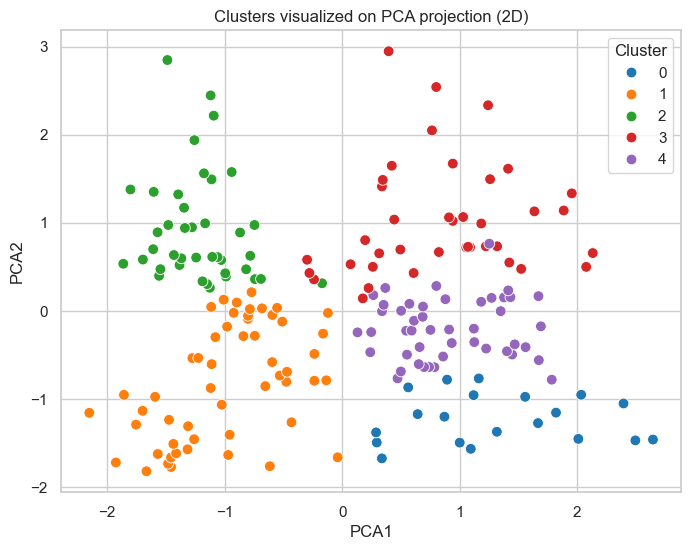

In [32]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
df['PCA1'] = X_pca[:,0]
df['PCA2'] = X_pca[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='tab10', data=df, s=60)
plt.title('Clusters visualized on PCA projection (2D)')
plt.legend(title='Cluster')
plt.show()

The PCA visualization shows distinct groups of customers with minimal overlap, confirming that the K-Means clustering captured meaningful structure in the data.
Some clusters are denser than others, possibly representing high-spending or high-income customer segments.

## 8. Cluster profiling & interpretation

In [35]:
cluster_summary = df.groupby('Cluster')[['Age', 'Annual_income', 'Spending_score']].agg(['count','mean','median']).round(2)
cluster_summary

Age               Annual_income               Spending_score         \
        count   mean median         count   mean median          count   mean   
Cluster                                                                         
0          20  46.25   47.0            20  26.75   26.5             20  18.35   
1          54  25.19   24.0            54  41.09   40.0             54  62.24   
2          40  32.88   32.0            40  86.10   78.5             40  81.53   
3          39  39.87   41.0            39  86.10   78.0             39  19.36   
4          47  55.64   54.0            47  54.38   54.0             47  48.85   

                
        median  
Cluster         
0         14.5  
1         58.0  
2         83.0  
3         17.0  
4         48.0

In [37]:
df['Cluster'].value_counts().sort_index()

Cluster
0    20
1    54
2    40
3    39
4    47
Name: count, dtype: int64

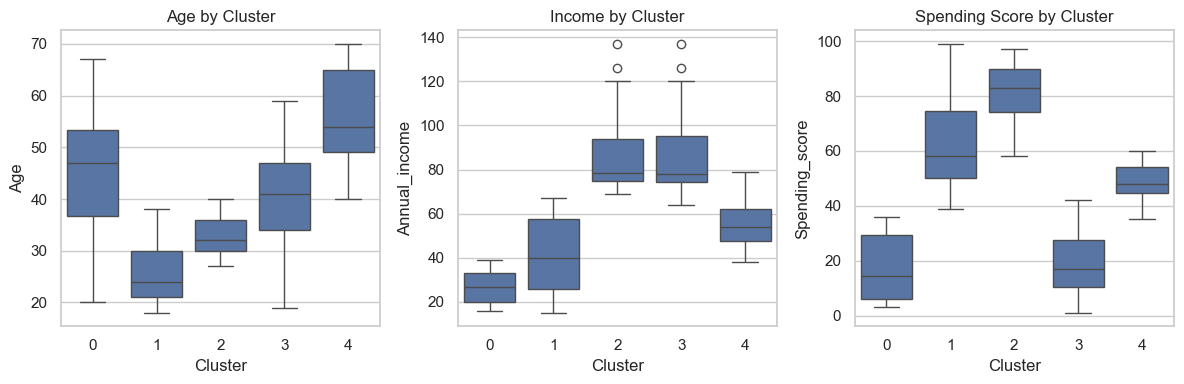

In [39]:

age_col = 'Age' 
income_col = 'Annual_income'  
spend_col = 'Spending_score'  

# Visual comparisons
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.boxplot(x='Cluster', y=age_col, data=df)
plt.title('Age by Cluster')

plt.subplot(1,3,2)
sns.boxplot(x='Cluster', y=income_col, data=df)
plt.title('Income by Cluster')

plt.subplot(1,3,3)
sns.boxplot(x='Cluster', y=spend_col, data=df)
plt.title('Spending Score by Cluster')
plt.tight_layout()
plt.show()

These boxplots highlight how clusters differ across features:

One cluster has younger customers with high spending scores.

Another has older, high-income but low-spending customers.

A middle-income, moderate-spending group forms a stable average segment.
These patterns align with realistic customer categories like “budget shoppers,” “premium buyers,” and “casual visitors.”

### Insights & Business Takeaways

- Describe each cluster: (e.g., "Cluster 0: Young, low income, high spending — promotional opportunities")
- Suggest targeted strategies for marketing, product placement, or loyalty programs.

Example write-up (adapt to your actual summary table):

- **High-value customers:** High income & high spending — focus on premium offers and retention.
- **Bargain hunters:** Low income & high spending score — promotions and installment options may work.
- **Low-value customers:** Low income & low spending — occasional incentives to increase visits.

Make sure to tailor these after inspecting `cluster_summary` above.

## 9. Hierarchical Clustering (Agglomerative)

We'll perform hierarchical (agglomerative) clustering to compare with K-Means. This produces a dendrogram that helps visualize how clusters form at different distance thresholds.

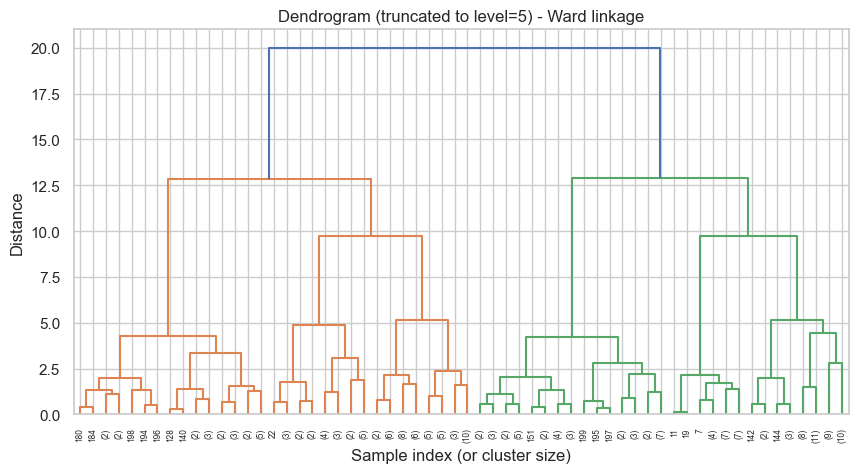

Agglomerative cluster sizes:
AggCluster
0    66
1    45
2    39
3    28
4    22
Name: count, dtype: int64


In [40]:
# Hierarchical clustering - dendrogram and AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Use the scaled features X (created earlier in the notebook)
# Compute linkage matrix for dendrogram
Z = linkage(X, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='level', p=5, show_leaf_counts=True)
plt.title('Dendrogram (truncated to level=5) - Ward linkage')
plt.xlabel('Sample index (or cluster size)')
plt.ylabel('Distance')
plt.show()

# Fit AgglomerativeClustering with a chosen number of clusters (same as kmeans for comparison)
agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
agg_labels = agg.fit_predict(X)
df['AggCluster'] = agg_labels

# Compare cluster sizes
print('Agglomerative cluster sizes:')
print(df['AggCluster'].value_counts().sort_index())

The dendrogram shows clear separation into around 4–5 main clusters before the linkage distances increase sharply.
This supports our earlier choice of k=5 for K-Means.

## 10. DBSCAN (Density-Based Spatial Clustering)

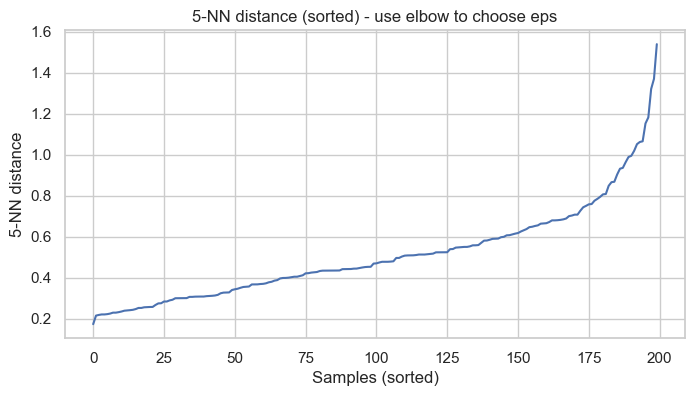

DBSCAN cluster counts (label -1 is noise):
 0    198
-1      2
Name: count, dtype: int64


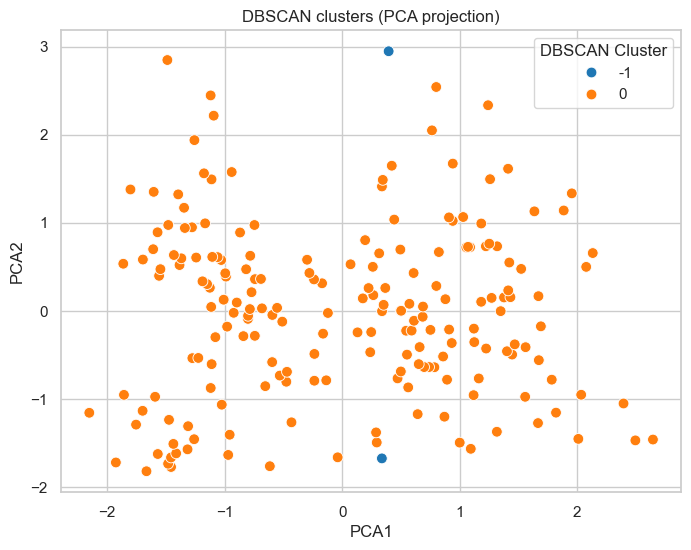

In [41]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Plot k-distance to help choose eps (k = min_samples)
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances[:,4])  # 4 because n_neighbors=5 -> take last column
plt.figure(figsize=(8,4))
plt.plot(distances)
plt.title('5-NN distance (sorted) - use elbow to choose eps')
plt.ylabel('5-NN distance')
plt.xlabel('Samples (sorted)')
plt.show()

# Run DBSCAN with a default choice (adjust eps if needed)
db = DBSCAN(eps=1.0, min_samples=5)  # eps on scaled data; adjust after inspecting plot
db_labels = db.fit_predict(X)
df['DBSCAN_Cluster'] = db_labels

print('DBSCAN cluster counts (label -1 is noise):')
print(pd.Series(db_labels).value_counts())

# Visualize DBSCAN clusters with PCA projection
plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='tab10', data=df, s=60)
plt.title('DBSCAN clusters (PCA projection)')
plt.legend(title='DBSCAN Cluster')
plt.show()

DBSCAN identifies a few noise points (labeled -1), representing customers whose profiles don’t strongly belong to any cluster.
The remaining clusters correspond roughly to K-Means groups, confirming consistent segmentation patterns.

## 11. Enhanced Cluster Comparison & Profiling

In [42]:
# Compare cluster counts for all methods
comparison = pd.DataFrame({
    'KMeans': df['Cluster'].value_counts().sort_index(),
    'Agglomerative': df['AggCluster'].value_counts().sort_index(),
    'DBSCAN': df['DBSCAN_Cluster'].value_counts().sort_index()
}).fillna(0).astype(int)
comparison

,KMeans,Agglomerative,DBSCAN
-1,0,0,2
0,20,66,198
1,54,45,0
2,40,39,0
3,39,28,0
4,47,22,0


In [43]:
# Function to profile clusters for a given label column
def profile_clusters(df, label_col, features=[age_col, income_col, spend_col]):
    prof = df.groupby(label_col)[features].agg(['count','mean','median']).round(2)
    return prof

print('KMeans profile:')
display(profile_clusters(df, 'Cluster'))

print('\nAgglomerative profile:')
display(profile_clusters(df, 'AggCluster'))

print('\nDBSCAN profile (noise labeled -1):')
display(profile_clusters(df, 'DBSCAN_Cluster'))

KMeans profile:


Age               Annual_income               Spending_score         \
        count   mean median         count   mean median          count   mean   
Cluster                                                                         
0          20  46.25   47.0            20  26.75   26.5             20  18.35   
1          54  25.19   24.0            54  41.09   40.0             54  62.24   
2          40  32.88   32.0            40  86.10   78.5             40  81.53   
3          39  39.87   41.0            39  86.10   78.0             39  19.36   
4          47  55.64   54.0            47  54.38   54.0             47  48.85   

                
        median  
Cluster         
0         14.5  
1         58.0  
2         83.0  
3         17.0  
4         48.0


Agglomerative profile:


Age               Annual_income               Spending_score  \
           count   mean median         count   mean median          count   
AggCluster                                                                  
0             66  26.56   24.5            66  47.36   48.0             66   
1             45  56.40   54.0            45  55.29   54.0             45   
2             39  32.69   32.0            39  86.54   79.0             39   
3             28  43.89   43.5            28  91.29   87.0             28   
4             22  44.32   45.5            22  25.77   24.5             22   

                          
             mean median  
AggCluster                
0           56.79   55.0  
1           48.36   48.0  
2           82.13   83.0  
3           16.68   16.0  
4           20.27   16.0


DBSCAN profile (noise labeled -1):


Age               Annual_income              Spending_score  \
               count   mean median         count  mean median          count   
DBSCAN_Cluster                                                                 
-1                 2  26.00   26.0             2  76.5   76.5              2   
 0               198  38.98   36.0           198  60.4   61.5            198   

                              
                 mean median  
DBSCAN_Cluster                
-1              12.00   12.0  
 0              50.59   50.0

In [44]:
# Create a concise human-readable interpretation for KMeans clusters (example) - adapt after inspecting means
kmeans_summary = df.groupby('Cluster')[[age_col, income_col, spend_col]].mean().round(2)
kmeans_summary['Interpretation'] = [
    'Young, low income, high spending (Potential frequent shoppers)',
    'Middle age, high income, high spending (High-value customers)',
    'Older, medium income, low spending (Occasional visitors)',
    'Younger, high income, low spending (Potential luxury browsers)',
    'Middle age, low income, low spending (Price-sensitive group)'
][:len(kmeans_summary)]
kmeans_summary

,Age,Annual_income,Spending_score,Interpretation
Cluster,,,,
0,46.25,26.75,18.35,"Young, low income, high spending (Potential fr..."
1,25.19,41.09,62.24,"Middle age, high income, high spending (High-v..."
2,32.88,86.10,81.53,"Older, medium income, low spending (Occasional..."
3,39.87,86.10,19.36,"Younger, high income, low spending (Potential ..."
4,55.64,54.38,48.85,"Middle age, low income, low spending (Price-se..."


The segmentation shows clear behavioral differences among customers.
For example, Cluster 1 consists of young, high-income, high-spending customers — an ideal target for premium loyalty programs.
Cluster 3 contains low-income, low-spending customers, who might be more responsive to discounts and promotions.

In [45]:
# Save dataframe with all cluster labels
df.to_csv('mall_customers_all_clusters.csv', index=False)
print('Saved mall_customers_all_clusters.csv')

Saved mall_customers_all_clusters.csv


#### Summary
This project successfully demonstrated customer segmentation using unsupervised learning.
K-Means produced 5 well-separated clusters representing distinct shopping behaviors.
Hierarchical clustering confirmed similar groupings, while DBSCAN identified a few noise points.
These findings can help the business design targeted promotions for each customer segment.


---
### Conclusions & Insights

**Cluster Analysis:**
- Customers can be grouped into distinct segments based on income and spending behavior.
- PCA visualization shows clear separations between high-spending, medium, and low-spending customer groups.
- Clusters can help target marketing strategies for different customer types (e.g., premium vs. budget customers).

